# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [41]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import datetime
from sklearn.preprocessing import MinMaxScaler

from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from pprint import pprint
from time import time

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
portfolio.head(3)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


# PreProcess portfolio dataframe

In [9]:
portfolioCopy=portfolio.copy()

In [10]:
def cleanPortfolio(portfolioCopy):
     # apply one hot encoding to channels column
    portfolioCopy['web'] = portfolioCopy['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolioCopy['email'] = portfolioCopy['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolioCopy['mobile'] = portfolioCopy['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolioCopy['social'] = portfolioCopy['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    
    portfolioCopy.rename(columns={"id": "offer_id"},inplace=True)
    
    del portfolioCopy["channels"]
    
    offerType=pd.get_dummies(portfolioCopy["offer_type"])
    
    portfolioCopy = pd.concat([portfolioCopy, offerType], axis=1, sort=False)
    del portfolioCopy["offer_type"]
    
    return portfolioCopy

In [11]:
portfolioCopy=cleanPortfolio(portfolioCopy)
portfolioCopy.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


# PreProcess profile dataframe

In [12]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [13]:
profileCopy=profile.copy()

In [14]:
def cleanProfile(profileCopy):
    profileCopy.rename(columns={"id": "person_id"},inplace=True)
    
    date=pd.to_datetime(profileCopy["became_member_on"], format='%Y%m%d', errors='ignore')
    
    del profileCopy["became_member_on"]
    profileCopy["became_member_on"]=date
    
    #Remove "other" gender
    profileCopy["gender"]=profileCopy[(profileCopy["gender"]=="M") | (profileCopy["gender"]=="F")]["gender"]
    
    # to remove None in gender rows
    profileCopy.dropna(subset=['gender'],inplace=True)
    
    #change male and female to 1 and 0
    le = preprocessing.LabelEncoder()
    profileCopy["gender"]=le.fit_transform(profileCopy["gender"].values)
    
    profileCopy["income"]=profileCopy["income"].fillna(profileCopy["income"].mean())
    
    todayDate = datetime.date.today()
    numberOfDays=todayDate-profileCopy["became_member_on"].dt.date
    numberOfDays=numberOfDays.dt.days
    profileCopy["memberShipDays"]= numberOfDays
    
    return profileCopy

In [15]:
profileCopy=cleanProfile(profileCopy)
profileCopy.head()

,age,gender,person_id,income,became_member_on,memberShipDays
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1005
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,1072
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,720
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,796
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,886


# PreProcess transaction dataframe

In [16]:
transcriptCopy=transcript.copy()
transcriptCopy.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [17]:
def cleanTranscript(transcriptCopy):
    transcriptCopy.rename(columns={"person": "person_id"},inplace=True)
    
    event=pd.get_dummies(transcriptCopy["event"])
    
    transcriptCopy = pd.concat([transcriptCopy, event], axis=1, sort=False)
    
    del transcriptCopy["event"]
    
    #Create new dataframe with the offer rows only exculding transaction
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcriptCopy[transcriptCopy['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

    del offer["value"]
    
    return offer

In [18]:
offer=cleanTranscript(transcriptCopy)
offer.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


# Analysis Part

Portfolio Dataframe analysis

In [19]:
portfolioCopy.head(5)

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd13a4d4748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd13a44c080>]], dtype=object)

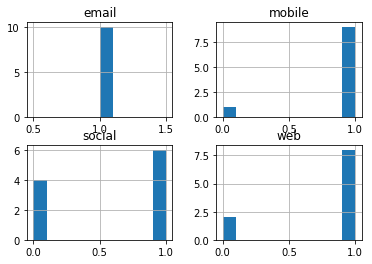

In [20]:
portfolioCopy[["web","email","mobile","social"]].hist()

In [21]:
portfolioCopy.shape

(10, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd13a402ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd13a31c400>]], dtype=object)

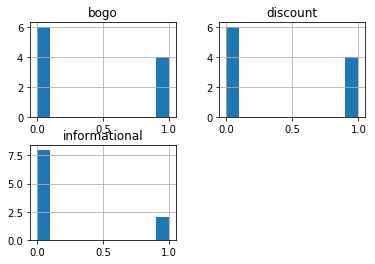

In [22]:
portfolioCopy[["bogo","discount","informational"]].hist()

In [23]:
#profile analysis
profileCopy.head()

,age,gender,person_id,income,became_member_on,memberShipDays
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1005
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,1072
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,720
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,796
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,886


Text(0.5,1,'Customer Age')

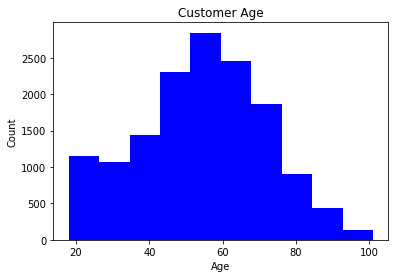

In [24]:
plt.hist(profileCopy['age'],  color = 'blue')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Age')

In [25]:
# people at 58 drink coffe from starbucks most
profileCopy['age'].mode()

0    58
dtype: int64

In [26]:
print("Minimum income:{}".format(profileCopy['income'].min()))
print("Average income:{}".format(profileCopy['income'].mean()))
print("Maximum income:{}".format(profileCopy['income'].max()))

Minimum income:30000.0
Average income:65435.707931294055
Maximum income:120000.0


Text(0.5,1,'Customer Income')

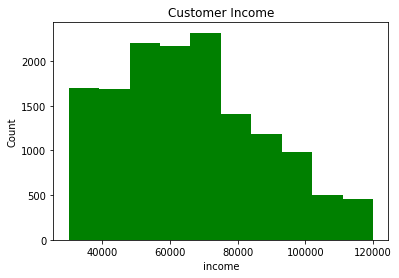

In [27]:
plt.hist(profileCopy['income'],  color = 'green')
plt.xlabel('income')
plt.ylabel('Count')
plt.title('Customer Income')

In [28]:
#The data appears to be right skewed as probability of buying from starbucks increasing with the income 

In [29]:
maleCount=profileCopy[profileCopy['gender']==1].shape[0]
femaleCount=profileCopy[profileCopy['gender']==0].shape[0]

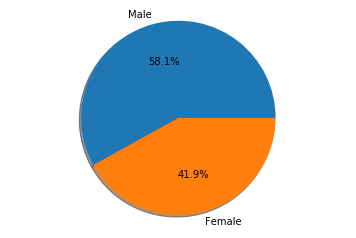

In [30]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Male', 'Female'
sizes = [maleCount, femaleCount]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [31]:
#Transcript Analysis

In [32]:
transcriptCopy.sample(10)

,event,person_id,time,value
239393,transaction,4c51ba3886b84781996ca15d42af505d,558,{'amount': 5.75}
116948,offer received,834f4242952a468f94501936eb33ce69,336,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
295370,offer completed,63996e7147c44a208bfdcd92ef0f49f7,666,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
151185,offer received,40399df768594afaa13aaca0b273608d,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
128238,transaction,2d2a9b0c54b04b2bb545a0158de57896,342,{'amount': 7.34}
177313,offer completed,1e90d5a75b1d47e6ac495c37399705da,432,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
143837,offer viewed,a85bfafef1214b86a1ecb57fca38f0ae,384,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
293960,offer viewed,0d52476253874872970140a42a277a2b,660,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
49883,transaction,fe10aba544fe423480cae848d9a03919,144,{'amount': 1.48}
238222,offer completed,90c964405bd74fa68a29af133eabe0ba,552,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...


# Build Model Part

In [33]:
offer.head(1)

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [34]:
portfolioCopy.head(1)

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0


In [35]:
profileCopy.head(1)

,age,gender,person_id,income,became_member_on,memberShipDays
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1005


In [36]:
def createModelDataFrame(profileCopy,portfolioCopy,offer):
    mergedData=pd.merge(profileCopy, offer, on='person_id')
    mergedData=pd.merge(mergedData, portfolioCopy, on='offer_id')
    mergedData.drop(["person_id","offer_id","became_member_on"],axis=1,inplace=True)
    
    return mergedData

In [37]:
mergedData=createModelDataFrame(profileCopy,portfolioCopy,offer)

In [38]:
mergedData.head(1)

,age,gender,income,memberShipDays,time,offer completed,offer received,offer viewed,transaction,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,55,0,112000.0,1005,408,0,1,0,0,5,7,5,1,1,1,0,1,0,0


In [39]:
target=mergedData["offer completed"]
mergedData.drop(["offer completed"],axis=1,inplace=True)
features=mergedData

In [40]:
mergedData.head(1)

,age,gender,income,memberShipDays,time,offer received,offer viewed,transaction,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,55,0,112000.0,1005,408,1,0,0,5,7,5,1,1,1,0,1,0,0


In [101]:
scaler = MinMaxScaler()
numerical = ['age', 'memberShipDays','time','difficulty','duration','reward','income']
mergedData[numerical] = scaler.fit_transform(mergedData[numerical])
mergedData.head(1)

,age,gender,income,memberShipDays,time,offer received,offer viewed,transaction,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,0.445783,0,0.911111,0.206253,0.571429,1,0,0,0.25,0.571429,0.5,1,1,1,0,1,0,0


In [47]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)

In [48]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''    
    results = {}
    beta = 0.5
    #Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    #Calculate the training time
    results['train_time'] = end - start
    # Get the predictions on the test set,then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    #Calculate the total prediction time
    results['pred_time'] = end - start
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    #Compute F-score on the the first 300 training samples
    #results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
    # Compute F-score on the test set
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)  
    # Success
    print (learner.__class__.__name__)
    print(" trained on ")
    print(sample_size)
    print(" samples.")
    # Print results
    pprint(results)
    # Return the results
    return results

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 40)  
clf_B = AdaBoostClassifier (random_state = 40)
clf_C = RandomForestClassifier(random_state = 40)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(X_train))
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)


DecisionTreeClassifier
 trained on 
1172
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.0038862228393554688,
 'train_time': 0.00823831558227539}
DecisionTreeClassifier
 trained on 
11729
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.0035800933837890625,
 'train_time': 0.010989189147949219}
DecisionTreeClassifier
 trained on 
117292
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.003724813461303711,
 'train_time': 0.14568710327148438}
AdaBoostClassifier
 trained on 
1172
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.20465421676635742,
 'train_time': 0.11973214149475098}
AdaBoostClassifier
 trained on 
11729
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.20784378051757812,
 'train_time': 0.5081243515014648}
AdaBoostClassifier
 trained on 
117292
 samples.
{'acc_test': 1.0,
 'acc_train': 1.0,
 'pred_time': 0.2050018310546875,
 'train_time': 5.449838399887085}
RandomForestClassifier
 trained on 
1172
 samples.